In [ ]:
# Importing all the libraries required for the model

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [10]:
# Importing dataset

df = pd.read_csv('creditcard.csv')

In [11]:
# Exploring the first few rows of the dataset

# The dataset assigns Class (0) to Non-Fraud Transactions and Class (1) to Fraud Transactions

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
# Checking the no. of rows and columns in dataset using the shape method

df.shape

(284807, 31)

In [15]:
# Checking for null values

df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

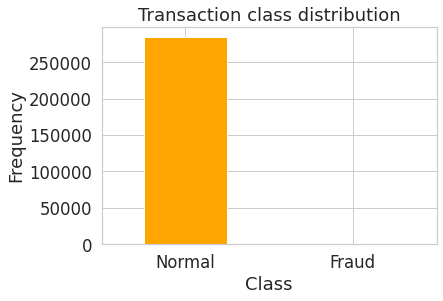

In [63]:
# Checking the number of transactions for each type of transaction class

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color='orange')

# Plotting the number of transactions in each transaction class 

plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [17]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [18]:
# Checking the shape of transactions classified as normal

normal.shape

(284315, 31)

**Checking the amount of money in each type of Transaction**

In [19]:
# Fraud transactions

frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [21]:
# Normal transactions

normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

**Visual Representation of Amount for each type of transaction**

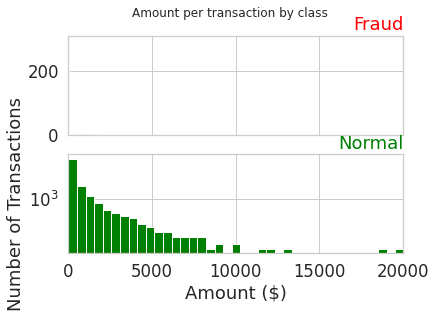

In [65]:
# Using Matplotlib to show amount per transaction

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins, color='red')
ax1.set_title('Fraud', loc = 'right', color= 'red')

ax2.hist(normal.Amount, bins = bins, color='green')
ax2.set_title('Normal', loc='right', color='green')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

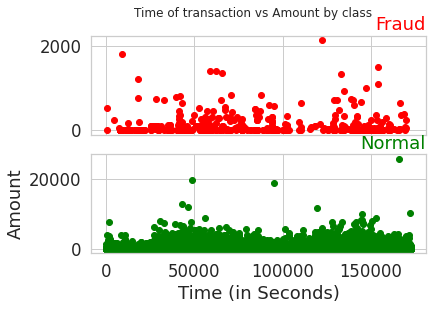

In [66]:
# Checking for Correlation by plotting time of transactions

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount, color='red')
ax1.set_title('Fraud', loc='right', color='red')

ax2.scatter(normal.Time, normal.Amount, color='green')
ax2.set_title('Normal', loc='right', color='green')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

By looking at the graph we can infer that Time is not a crucial factor in distinguishing between normal and fraud transactions, hence dropping it makes sense.

In [35]:
data = df.drop(['Time'], axis=1)

In [38]:
# Preprocessing the amount using StrandardScaler

from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

**Using Autoencoders to build the fraud detection model**

The purpose of using Autoencoders is to focus the database on learning the normal transactions

In [42]:
non_fraud = data[data['Class'] == 0] #.sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

# Train - Test Split

In [43]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

# Autoencoder Model

In [44]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

# Training the model

In [45]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

# Scaling the values

In [49]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 2s 70ms/step - loss: 0.2405 - val_loss: 0.2395
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2402 - val_loss: 0.2392
Epoch 3/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2399 - val_loss: 0.2390
Epoch 4/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2396 - val_loss: 0.2387
Epoch 5/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2394 - val_loss: 0.2384
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2391 - val_loss: 0.2381
Epoch 7/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2388 - val_loss: 0.2378
Epoch 8/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2385 - val_loss: 0.2375
Epoch 9/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2382 - val_loss: 0.2372
Epoch 10/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2379 - val_loss: 0.2369


# Getting Hidden Representative Data

In [50]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

# Model Prediction

In [51]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

# Getting the representation data

In [52]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

# Train, Test, Split

In [67]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

In [68]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       767
         1.0       1.00      0.75      0.86       106

    accuracy                           0.97       873
   macro avg       0.98      0.88      0.92       873
weighted avg       0.97      0.97      0.97       873


Accuracy Score:  0.9702176403207331
